In [1]:
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'

import tensorflow as tf
tf.compat.v1.disable_eager_execution()  # Must be placed before other TF imports

import math
import machine_learning_datasets as mldatasets  # Custom dataset loader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from catboost import CatBoostClassifier  # Gradient boosting classifier
import matplotlib.pyplot as plt
import seaborn as sns

# Alibi library for explainable AI
from alibi.utils.mapping import ohe_to_ord, ord_to_ohe
from alibi.explainers import AnchorTabular, CounterfactualProto

import shap  # SHAP values for feature importance
import witwidget  # What-If Tool for model visualization
from witwidget.notebook.visualization import WitWidget, WitConfigBuilder

In [2]:
# Check TensorFlow version compatibility
print(tf.__version__)

2.20.0


In [3]:
# Disable eager execution for TensorFlow 1.x compatibility
# tf.compat.v1.disable_eager_execution()
print('Eager execution enabled: ', tf.executing_eagerly())

Eager execution enabled:  False


In [4]:
# THE MISSION: ASSESSING FAIRNESS IN CRIMINAL RISK PREDICTIONS
#
# THE CONTEXT & THE PROBLEM: HIGH-STAKES, OPAQUE AI
# - Domain: Criminal Risk Assessment Instruments (RAIs), used by judges and parole boards.
# - Impact: These tools guide high-impact, life-changing decisions like pre-trial detention and parole.
# - The Black Box Issue: Even if based on statistical models, the tools are often proprietary, making them effectively black boxes. We don't know exactly how a risk score was calculated.
# - Performance Issues: Predictive performance is often surprisingly low (median AUCs between 0.57 and 0.74).
# - The Fairness Dilemma: As AI makes more life-changing decisions, fairness becomes a critical and integral part of interpretation.
# - The Proxy Bias Problem: While explicit demographic features like race and gender have been removed from modern RAIs, other questions can act as strong proxies for them, perpetuating structural inequality and unfair biases.
#   - Example questions: "How often have you moved?", "Are you a suspected gang member?"
#
# THE SPECIFIC CASE STUDY: THE COMPAS TOOL
# - Client: An investigative journalist.
# - Tool in Question: COMPAS (Correctional Offender Management Profiling for Alternative Sanction), a widely used RAI.
# - The Scenario: An African American defendant was deemed high-risk for recidivism (relapsing into criminal behavior) by COMPAS.
#   - This score led a judge to detain him for months.
#   - He was later found not guilty and has not re-offended in over five years.
#   - This is a clear case of a FALSE POSITIVE with severe real-world consequences.
# - The Journalist's Goal: To use data science to investigate whether there was unfair racial bias in this specific case.
#
# ⚠ THE CHALLENGE: LACK OF ACCESS
# - A critical constraint of the mission is that we DO NOT have access to the key components:
#   1. The proprietary COMPAS model itself.
#   2. The 137 answered questions (the original features) for the defendants.
# - What we DO have:
#   - The final COMPAS scores for each defendant (these will be our LABELS).
#   - Demographic and criminal history data for the defendants (these will be our FEATURES).
#   - The actual recidivism outcomes.
#
# THE APPROACH: A THREE-PART STRATEGY
#
# 1. ✓ TRAIN A PROXY MODEL:
#    - Since we can't analyze the real model, we will train our own model (a CatBoost classifier) to approximate it.
#    - We will use the available features to predict the COMPAS scores.
#    - By understanding our proxy model, we can infer how the original COMPAS model might be behaving.
#
# 2. ✓ ANCHOR EXPLANATIONS:
#    - This method will be used to find the "anchors" – a set of rules that are sufficient to "lock in" a specific prediction.
#    - Goal: To understand the decision boundaries of our proxy model and find out *why* the defendant was predicted to be high-risk.
#
# 3. ✓ COUNTERFACTUAL EXPLANATIONS:
#    - This method examines *why a decision was not made* by finding the smallest change to the input that would flip the prediction.
#    - Goal: This is particularly powerful for inspecting fairness. (e.g., "Would the prediction have changed if the defendant's race were different, holding all else equal?").
#    - Tools: An unbiased counterfactual method and the What-If Tool (WIT).

# Understanding and Preparing the Data

In [6]:
# Load the recidivism dataset
# This dataset contains information about defendants and their likelihood to reoffend
recidivism_df = mldatasets.load("recidivism-risk")

https://storage.googleapis.com/what-if-tool-resources/computefest2019/cox-violent-parsed_filt.csv downloaded to D:\Tutorials\2025\XAI\06_Anchors_and_Counterfactual_Explanations\data\cox-violent-parsed_filt.csv
1 dataset files found in D:\Tutorials\2025\XAI\06_Anchors_and_Counterfactual_Explanations\data folder
parsing D:\Tutorials\2025\XAI\06_Anchors_and_Counterfactual_Explanations\data\cox-violent-parsed_filt.csv


C:\Users\ASUS\miniconda3\envs\DataVis\Lib\site-packages\machine_learning_datasets\sources\source.py:170: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  return pd.read_csv(fpath, **csvopts)[csvopts['usecols']]
C:\Users\ASUS\miniconda3\envs\DataVis\Lib\site-packages\machine_learning_datasets\sources\source.py:170: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  return pd.read_csv(fpath, **csvopts)[csvopts['usecols']]


In [7]:
recidivism_df

,sex,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_jail_in,c_jail_out,c_charge_degree,is_recid,days_b_screening_arrest,decile_score,score_text
0,Male,69,Other,0,0,0,0,2013-08-13 06:03:00,2013-08-14 05:41:00,(F3),0,-1.0,1,Low
1,Male,69,Other,0,0,0,0,2013-08-13 06:03:00,2013-08-14 05:41:00,(F3),0,-1.0,1,Low
2,Male,31,Caucasian,0,0,0,0,NaT,NaT,NaN,-1,NaN,5,Medium
3,Male,34,African-American,0,0,0,0,2013-01-26 03:45:00,2013-02-05 05:36:00,(F3),1,-1.0,3,Low
4,Male,24,African-American,0,0,1,4,2013-04-13 04:58:00,2013-04-14 07:02:00,(F3),1,-1.0,4,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18311,Female,31,African-American,0,0,0,5,2014-12-28 10:14:00,2015-01-07 11:42:00,(M1),0,-1.0,6,Medium
18312,Male,57,Other,0,0,0,0,2014-01-13 05:48:00,2014-01-14 07:49:00,(F2),0,-1.0,1,Low
18313,Female,33,African-American,0,0,0,3,2014-03-08 08:06:00,2014-03-09 12:18:00,(M1),0,-1.0,2,Low
18314,Female,23,Hispanic,0,0,0,2,2014-06-28 12:16:00,2014-06-30 11:19:00,(F3),1,-2.0,4,Low


In [8]:
recidivism_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18316 entries, 0 to 18315
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   sex                      18316 non-null  object        
 1   age                      18316 non-null  int8          
 2   race                     18316 non-null  object        
 3   juv_fel_count            18316 non-null  int8          
 4   juv_misd_count           18316 non-null  int8          
 5   juv_other_count          18316 non-null  int64         
 6   priors_count             18316 non-null  int8          
 7   c_jail_in                17019 non-null  datetime64[ns]
 8   c_jail_out               17019 non-null  datetime64[ns]
 9   c_charge_degree          17449 non-null  object        
 10  is_recid                 18316 non-null  int8          
 11  days_b_screening_arrest  17019 non-null  float64       
 12  decile_score             18316 n

In [9]:
recidivism_df.describe()

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_jail_in,c_jail_out,is_recid,days_b_screening_arrest,decile_score
count,18316.000000,18316.000000,18316.000000,18316.000000,18316.000000,17019,17019,18316.000000,17019.000000,18316.000000
mean,34.019273,0.076873,0.098439,0.124263,3.913191,2013-11-27 20:46:12.332099328,2013-12-23 08:56:28.566896128,0.414774,4.302485,4.997052
min,18.000000,0.000000,0.000000,0.000000,0.000000,2013-01-01 01:31:00,2013-01-02 01:12:00,-1.000000,-597.000000,-1.000000
25%,25.000000,0.000000,0.000000,0.000000,0.000000,2013-04-24 19:07:30,2013-05-17 07:06:30,0.000000,-1.000000,2.000000
50%,31.000000,0.000000,0.000000,0.000000,2.000000,2013-11-14 01:35:00,2013-12-08 02:32:00,0.000000,-1.000000,5.000000
75%,41.000000,0.000000,0.000000,0.000000,5.000000,2014-06-01 08:33:00,2014-06-26 12:26:00,1.000000,0.000000,8.000000
max,96.000000,20.000000,13.000000,17.000000,43.000000,2016-03-11 10:26:00,2020-01-01 00:00:00,1.000000,1057.000000,10.000000
std,11.667811,0.464272,0.517639,0.524537,5.299864,NaN,NaN,0.576449,81.159881,2.937569


In [10]:
recidivism_df = recidivism_df.dropna(subset=['c_charge_degree', 'c_jail_in', 'c_jail_out', 'days_b_screening_arrest', 'score_text'])
recidivism_df = recidivism_df[recidivism_df['is_recid'] != -1]
recidivism_df = recidivism_df[recidivism_df['juv_fel_count'] < 3]
recidivism_df = recidivism_df[recidivism_df['juv_misd_count'] < 2]
recidivism_df = recidivism_df[recidivism_df['juv_other_count'] < 2]
recidivism_df = recidivism_df[recidivism_df['priors_count'] < 14]

recidivism_df = mldatasets.make_dummies_with_limits(recidivism_df, 'sex')
recidivism_df = mldatasets.make_dummies_with_limits(recidivism_df, 'race',
                                                   min_recs= 1)
recidivism_df = mldatasets.make_dummies_with_limits(recidivism_df, 'c_charge_degree',
                                                   min_recs=106)

# After all make_dummies_with_limits calls
bool_cols = recidivism_df.select_dtypes(include='bool').columns
recidivism_df[bool_cols] = recidivism_df[bool_cols].astype(np.uint8)

recidivism_df['compas_score'] = np.where(recidivism_df['score_text'].isin(['Medium', 'High']), 1, 0).astype(np.uint8)
recidivism_df = recidivism_df.drop(columns=['c_jail_in', 'c_jail_out', 'days_b_screening_arrest', 'decile_score', 'score_text'])

recidivism_df = recidivism_df.reset_index(drop=True)

In [11]:
recidivism_df

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,is_recid,sex_Female,sex_Male,race_African-American,race_Asian,...,race_Other,c_charge_degree_(F1),c_charge_degree_(F2),c_charge_degree_(F3),c_charge_degree_(F7),c_charge_degree_(M1),c_charge_degree_(M2),c_charge_degree_(MO3),c_charge_degree_Other,compas_score
0,69,0,0,0,0,0,0,1,0,0,...,1,0,0,1,0,0,0,0,0,0
1,69,0,0,0,0,0,0,1,0,0,...,1,0,0,1,0,0,0,0,0,0
2,34,0,0,0,0,1,0,1,1,0,...,0,0,0,1,0,0,0,0,0,0
3,24,0,0,1,4,1,0,1,1,0,...,0,0,0,1,0,0,0,0,0,0
4,24,0,0,1,4,1,0,1,1,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15205,31,0,0,0,5,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,1
15206,57,0,0,0,0,0,0,1,0,0,...,1,0,1,0,0,0,0,0,0,0
15207,33,0,0,0,3,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
15208,23,0,0,0,2,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [12]:
recidivism_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15210 entries, 0 to 15209
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   age                    15210 non-null  int8 
 1   juv_fel_count          15210 non-null  int8 
 2   juv_misd_count         15210 non-null  int8 
 3   juv_other_count        15210 non-null  int64
 4   priors_count           15210 non-null  int8 
 5   is_recid               15210 non-null  int8 
 6   sex_Female             15210 non-null  uint8
 7   sex_Male               15210 non-null  uint8
 8   race_African-American  15210 non-null  uint8
 9   race_Asian             15210 non-null  uint8
 10  race_Caucasian         15210 non-null  uint8
 11  race_Hispanic          15210 non-null  uint8
 12  race_Native_American   15210 non-null  uint8
 13  race_Other             15210 non-null  uint8
 14  c_charge_degree_(F1)   15210 non-null  uint8
 15  c_charge_degree_(F2)   15210 non-nul

In [13]:
recidivism_df.describe()

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,is_recid,sex_Female,sex_Male,race_African-American,race_Asian,...,race_Other,c_charge_degree_(F1),c_charge_degree_(F2),c_charge_degree_(F3),c_charge_degree_(F7),c_charge_degree_(M1),c_charge_degree_(M2),c_charge_degree_(MO3),c_charge_degree_Other,compas_score
count,15210.000000,15210.000000,15210.000000,15210.000000,15210.000000,15210.000000,15210.000000,15210.000000,15210.000000,15210.000000,...,15210.000000,15210.000000,15210.000000,15210.000000,15210.000000,15210.000000,15210.000000,15210.000000,15210.000000,15210.000000
mean,33.687114,0.040565,0.037212,0.056082,2.923537,0.462656,0.194477,0.805523,0.514135,0.004208,...,0.050493,0.017028,0.085470,0.581525,0.010322,0.222880,0.072847,0.006969,0.002959,0.493623
std,11.535433,0.229344,0.189288,0.230087,3.286604,0.498620,0.395811,0.395811,0.499817,0.064733,...,0.218967,0.129381,0.279589,0.493325,0.101076,0.416192,0.259893,0.083192,0.054314,0.499976
min,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,30.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,40.000000,0.000000,0.000000,0.000000,5.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,96.000000,2.000000,1.000000,1.000000,13.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
# There are only nine features, but they become 22 columns because of the categorical encoding:
# • age: Continuous; the age of the defendant (between 18 and 96).

# • juv_fel_count: Ordinal; the number of juvenile felonies (between 0 and 2).

# • juv_misd_count: Ordinal; the number of juvenile misdemeanors (between 0 and 1).

# • juv_other_count: Ordinal; the number of juvenile convictions that are neither felonies nor 
# misdemeanors (between 0 and 1).

# • priors_count: Ordinal; the number of prior crimes committed (between 0 and 13).

# • is_recid: Binary; did the defendant recidivate within 2 years (1 for yes, 0 for no)?
                                                              
# • sex: Categorical; the gender of the defendant.

# • race: Categorical; the race of the defendant.

# • c_charge_degree: Categorical; the degree of what the defendant is currently being charged 
# with. The United States classifies criminal offenses as felonies, misdemeanors, and infractions, 
# ordered from most serious to least. These are subclassified in the form of degrees, which go 
# from 1st (most serious offenses) to 3rd or 5th (least severe). However, even though this is standard 
# for federal offenses, it is tailored to state law. For felonies, Florida (http://www.dc.state.
# fl.us/pub/scoresheet/cpc_manual.pdf) has a level system that determines the severity of a 
# crime regardless of the degree, and this goes from 10 (most severe) to 1 (least). 
# The categories of this feature are prefixed with F for felonies and M for misdemeanors. They 
# are followed by a number, which is a level for felonies and a degree for misdemeanors.
                                                                
# • compas_score: Binary; COMPAS scores defendants as “low,” “medium,” or “high” risk. In prac
# tice, “medium” is often treated as “high” by decision-makers, so this feature has been converted 
# to binary to reflect this behavior: 1: high/medium risk and 0: low risk.

# Examining Predictive Bias with Confusion Matrices

In [15]:
# There are two binary features in the dataset. The first one is the recidivism risk prediction made by 
# COMPAS (compas_score). The second one (is_recid) is the ground truth because it’s what happened 
# within 2 years of the defendant’s arrest. Just as you would with the prediction of any model against its 
# training labels, you can build confusion matrices with these two features. 

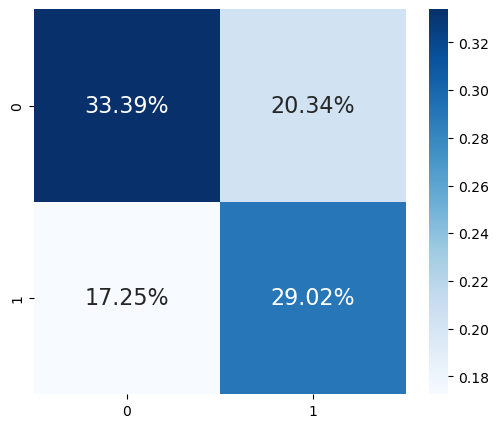

In [16]:
# Create confusion matrix comparing actual recidivism vs COMPAS predictions
# This shows how well the COMPAS algorithm performs
cf_matrix = metrics.confusion_matrix(
    recidivism_df.is_recid,  # Actual recidivism
    recidivism_df.compas_score  # COMPAS risk score prediction
)

# Visualize confusion matrix as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(
    cf_matrix/np.sum(cf_matrix),  # Normalize to percentages
    annot=True,  # Show values in cells
    fmt='.2%',  # Format as percentages
    cmap='Blues',  # Color scheme
    annot_kws={'size':16}  # Annotation text size
)
plt.show()

In [17]:
# the COMPAS model’s predictive performance is not very good, especially if we 
# assume that criminal justice decision-makers are taking medium or high risk assessments at face value. 
# It also tells us that FP and FNs occur at a similar rate. Nevertheless, simple visualizations such as the 
# confusion matrix obscure predictive disparities between subgroups of a population. We can quickly 
# compare disparities between two subgroups that historically have been treated differently by the United 
# States criminal justice system. To this end, we first subdivide our DataFrame into two DataFrames: one 
# for Caucasians (recidivism_c_df) and another for African Americans (recidivism_aa_df). Then we 
# can generate confusion matrices for each DataFrame and plot them side by side 

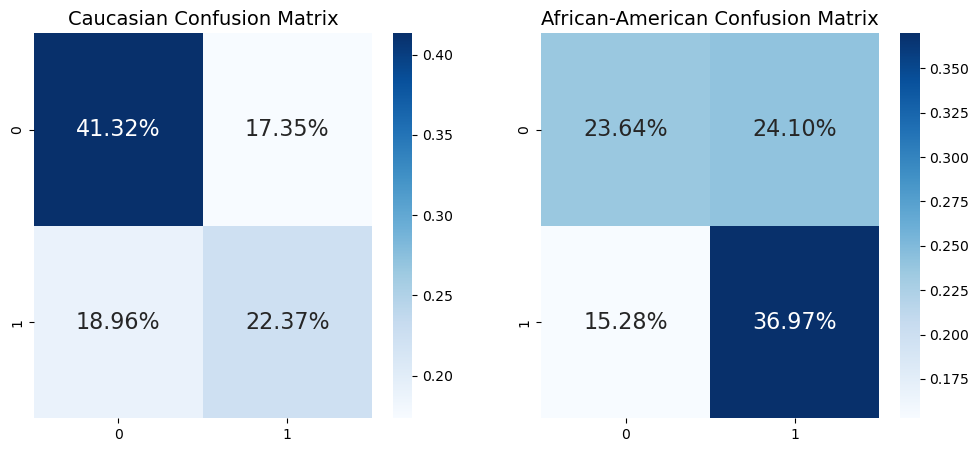

	African-American FPR:	50.5%
	Caucasian FPR:		29.6%
	Ratio FPRs:		1.71 x


In [18]:
# Compare false positive rates (FPR) between racial groups
# Higher FPR means the algorithm incorrectly predicts recidivism more often

# Filter data by race
recidivism_c_df = recidivism_df[recidivism_df['race_Caucasian'] == 1]
recidivism_aa_df = recidivism_df[recidivism_df['race_African-American'] == 1]

# Compare confusion matrices and calculate FPR ratio
_ = mldatasets.compare_confusion_matrices(
    recidivism_c_df.is_recid, 
    recidivism_c_df.compas_score,
    recidivism_aa_df.is_recid,
    recidivism_aa_df.compas_score,
    'Caucasian', 
    'African-American', 
    compare_fpr=True  # Show false positive rate comparison
)

In [19]:
# At a glance, you can tell that it’s like the confusion matrix 
# for Caucasians has been flipped 90 degrees to form the African American confusion matrix, and even 
# then, it is still less unfair. Pay close attention to the difference between FPs and TNs. As a Caucasian 
# defendant, a result is less than half as likely to be an FP than a TN, but as an African American, it 
# is a few percentage points more likely. In other words, an African American defendant who doesn’t 
# re-offend is predicted to be at risk of recidivating more than half of the time

# Data Preparation

In [20]:
# 4390 4391 African-american
# 5270 8452 caucassian
# 2280 2281 2282 2283 2284 2285 hispanic

# 0  2  33

In [21]:
# Set random seed for reproducibility
rand = 36
np.random.seed(rand)

# Prepare features (X) and target variable (y)
y = recidivism_df['compas_score']  # Target: recidivism risk score
X = recidivism_df.drop(['compas_score', 'is_recid'], axis=1).copy()

# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,  # 20% for testing
    random_state=rand  # Reproducible split
)

# # Select three specific individuals for detailed analysis
# idx_aa1 = 4390   # African-American defendant
# idx_aa2 = 4391
# idx_c1 = 5270   # Caucasian defendant
# idx_c2 = 8452   # Caucasian defendant
# idx_h = 2280    # Hispanic defendant  


# eval_idxs = X_test.index.isin([idx_aa1, idx_aa2, idx_c1, idx_c2, idx_h])
# X_test[eval_idxs]

#### Modeling

In [22]:
# PROXY MODELS vs. SURROGATE MODELS
# While the terms are often used interchangeably, the text makes a specific semantic distinction for this mission.
#
# ✓ SURROGATE MODEL:
#   - Implies SUBSTITUTION.
#   - The goal is interpretation, so you train a simple, white-box model on the original model's predictions
#     to understand its logic.
#
# ⚠ PROXY MODEL (as used here):
#   - Implies REPRESENTATION.
#   - We are using this term because we LACK THE ORIGINAL TRAINING DATA (the 137 COMPAS questions).
#   - We are using a different set of features to approximate the black-box model's output.
#   - Since we cannot truly substitute the original model, we cannot use a simple surrogate for interpretation.
#   - The Goal → Use a COMPLEX and POWERFUL model that can make up for the difference in training data.
#
# THE CHOSEN MODEL: CATBOOST
# - What it is: An efficient, high-performance boosted ensemble tree method.
#
# - KEY CHARACTERISTICS & COMPARISONS:
#   - Similar to LightGBM, but with some key differences.
#   - Sampling Method: Uses MVS (Minimal Variance Sampling) instead of LightGBM's GOSS.
#   - Tree Growth: Grows balanced trees (depth-wise), unlike LightGBM's leaf-wise growth.
#
# - THE "CAT" IN CATBOOST:
#   - Its name comes from its standout feature: a powerful and automatic encoding method for CATEGORICAL features.
#
# - MAJOR STRENGTHS (Why it's a good choice):
#   - Excellent at handling categorical features without bias.
#   - Particularly good at tackling overfitting.
#   - Handles class imbalances well.

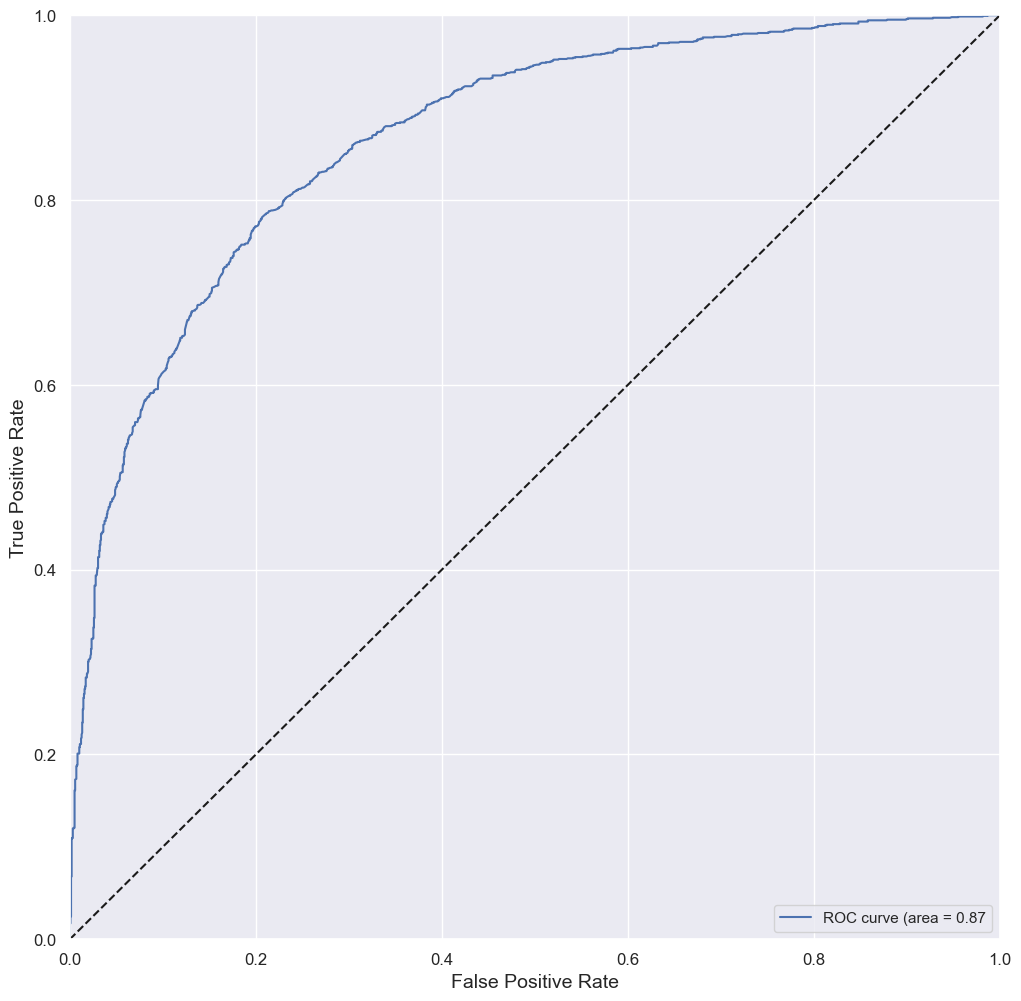

Accuracy_train:  0.8685		Accuracy_test:   0.7870
Precision_test:  0.7766		Recall_test:     0.7798
ROC-AUC_test:    0.8667		F1_test:         0.7782		MCC_test: 0.5733


In [23]:
# Configure plotting style
orig_plt_params = plt.rcParams
sns.set()

# Initialize CatBoost classifier with hyperparameters
cb_mdl = CatBoostClassifier(
    iterations=500,      # Number of boosting iterations
    learning_rate=0.5,   # Step size for gradient descent
    depth=8              # Maximum tree depth
)

# Train the model
fitted_cb_mdl = cb_mdl.fit(X_train, y_train, verbose=False)

# Evaluate model performance on train and test sets
y_train_cb_pred, y_test_cb_prob, y_test_cb_pred = \
    mldatasets.evaluate_class_mdl(
        fitted_cb_mdl, 
        X_train, X_test, 
        y_train, y_test
    )

In [24]:
# The predictive performance for the model is reasonably accurate considering it’s a proxy model meant 
# to only approximate the real thing with different, yet related, data.

# Getting Acquainted to our “Instance of Interest”

In [25]:
# The journalist reached out to you with a case in mind: the African American defendant who was falsely 
# predicted to have a high risk of recidivism. Since our focus is racial bias, we’d like to compare 
# it with similar instances but of different races. To that end, we found case (Caucasian) and (Hispanic).

In [26]:
# Select three specific individuals for detailed analysis
idx_aa = 4390  # African-American defendant
idx_h = 2280    # Hispanic defendant   
idx_c = 8452   # Caucasian defendant

# Extract these instances from test set
eval_idxs = X_test.index.isin([idx_aa, idx_h, idx_c])
X_test_evals = X_test[eval_idxs]

# Create comparison dataframe showing actual vs predicted for these instances
eval_compare_df = pd.concat([
    pd.DataFrame({'y': y_test[eval_idxs]}, index=[idx_c, idx_h, idx_aa]),
    pd.DataFrame({'y_pred': y_test_cb_pred[eval_idxs]}, index=[idx_c, idx_h, idx_aa]),
    X_test_evals
], axis=1).transpose()

eval_compare_df

,8452,2280,4390
y,0,0,1
y_pred,0,0,1
age,24,23,23
juv_fel_count,0,0,0
juv_misd_count,0,0,0
juv_other_count,0,0,0
priors_count,2,2,2
sex_Female,0,0,0
sex_Male,1,1,1
race_African-American,0,0,1


In [27]:
# the predictions match the true labels, and our main instance of interest was the only one predicted as a medium or high risk 
# of recidivism. Besides race, the only other differences are with c_charge_degree and one minor age difference

# we will pay close attention to these differences to see whether they played a large role in 
# producing the prediction difference. All the methods we will cover will complete the picture 
# of what can determine or change the proxy model’s decision, and, potentially, the COMPAS model by extension.

## Understanding Anchor Explanations

In [28]:
# ANCHORS vs. LIME: THE KEY DIFFERENCE
# Both are model-agnostic, perturbation-based methods for local interpretation, but their goals are different.
#
# - LIME: Approximates a local DECISION BOUNDARY.
#   - It asks: "What linear model best separates the classes right here at this specific point?"
#
# - ANCHORS: Identifies a DECISION REGION.
#   - It asks: "What is the simplest set of rules that are sufficient to 'lock in' this prediction for this point and its neighbors?"
#
# - The final output of Anchors is a set of "scoped rules" (e.g., IF `age < 25` AND `priors > 2` THEN prediction is HIGH RISK).
#
# THE CORE CONCEPTS OF ANCHORS
#
# ✓ PRECISION:
#   - Definition: The percentage of perturbed samples in the neighborhood to which the anchor rule applies AND for which the model makes the same prediction.
#   - In simple terms: How reliable is this rule? A 95% precision means the rule holds true for 95% of similar cases.
#
# ✓ COVERAGE:
#   - Definition: The percentage of the local neighborhood (perturbation space) to which the rule applies.
#   - In simple terms: How broadly applicable is this rule? A rule with low coverage is very specific and only applies to a small fraction of similar cases.
#
# ✓ THE TRADE-OFF:
#   - There is an inherent trade-off between precision and coverage. A very simple rule might have high coverage but low precision. A very complex, specific rule might have high precision but low coverage.
#
# HOW ANCHORS ARE FOUND: THE MULTI-ARMED BANDIT (MAB) APPROACH
#
# - ⚠ NO SURROGATE MODEL: Unlike LIME, Anchors DO NOT fit a local surrogate linear model.
# - The Method: It uses a reinforcement learning algorithm to efficiently search for the best decision rules.
# - The Algorithm: Specifically, it uses KL-LUCB (Kullback-Leibler divergence Lower and Upper Confidence Bounds), which is derived from a Multi-Armed Bandit (MAB) algorithm.
#
# THE MAB ANALOGY FOR ANCHORS (THE CASINO PROBLEM)
#
# - The MAB Problem: How to maximize your payoff at a casino with many slot machines ("multi-armed bandits") and limited money. You don't know which machine is best.
#
# - MAPPING THE ANALOGY TO ANCHORS:
#   - The Casino Player → The Anchor algorithm.
#   - The Slot Machines → All possible candidate decision rules (e.g., `age < 30`, `priors_count > 2`).
#   - The Payoff from a machine → The PRECISION yielded by a specific rule.
#   - The Limited Funds → The limited computational budget for testing rules.
#
# - THE CORE CHALLENGE (EXPLORATION vs. EXPLOITATION):
#   - The algorithm must intelligently balance:
#     - EXPLORATION: Trying out new, unknown decision rules to see if they are good.
#     - EXPLOITATION: Sticking with and refining rules that have already shown high precision.
#
# - The Goal: To efficiently find the decision rule with the highest possible precision in the shortest amount of time.

### Preparations for Anchor and Counterfactual Explanations with Alibi

In [29]:
# Several small steps need to be performed to help the alibi library produce human-friendly expla
# nations. The first one pertains to the prediction since the model may output a 1 or 0, but it’s easier to 
# understand a prediction by its name. To help us with this, we need a list with the class names where 
# the 0 position matches our negative class name and 1 matches the positive one

In [30]:
# Define human-readable class names
class_names = ['Low Risk', 'Medium/High Risk']

In [31]:
# Prepare single instance for analysis (African-American defendant)
X_test_eval = np.expand_dims(
    X_test.values[X_test.index.get_loc(idx_aa)], 
    axis=0  # Add batch dimension
)
print(X_test_eval)

[[23  0  0  0  2  0  1  1  0  0  0  0  0  0  0  0  1  0  0  0  0]]


In [32]:
# A problem with making human-friendly explanations arises when you have OHE categories. To both 
# the machine learning model and the explainer, each OHE feature is separate from the others. Still, to 
# the human interpreting the outcomes, they cluster together as categories of their original features.
# The alibi library has several utility functions to deal with this problem, such as ohe_to_ord, which 
# takes a one-hot-encoded instance and puts it in an ordinal format. To use this function, we first define 
# a dictionary (cat_vars_ohe) that tells alibi where the categorical variables are in our features and 
# how many categories each one has. For instance, in our data, gender starts at the 5th index and has two 
# categories, which is why our cat_vars_ohe dictionary begins with 5: 2. Once you have this dictionary, 
# ohe_to_ord can take your instance (X_test_eval) and output it in ordinal format, where each categor
# ical variable takes up a single feature. This utility function will prove useful for Alibi’s counterfactual 
# explanations, where the explainer will need this dictionary to map categorical features together

In [33]:
# Map one-hot encoded features back to ordinal values
# Format: {start_col: num_categories}
cat_vars_ohe = {
    5: 2,   # Sex: Female/Male (2 categories)
    7: 6,   # Race: 6 categories
    13: 8   # Charge degree: 8 categories
}

# Convert one-hot encoded features to ordinal
print(ohe_to_ord(X_test_eval, cat_vars_ohe)[0])

[[23  0  0  0  2  1  0  3]]


In [34]:
# For when it’s in ordinal format, Alibi will need a dictionary that provides names for each category 
# and a list of feature names

# Define categorical variable mappings for interpretability
category_map = {
    5: ['Female', 'Male'],
    6: ['African-American', 'Asian', 'Caucasian',
        'Hispanic', 'Native American', 'Other'],
    7: ['Felony 1st Degree', 'Felony 2nd Degree',
        'Felony 3rd Degree', 'Felony 7th Degree',
        'Misdemeanor 1st Degree', 'Misdemeanor 2nd Degree',
        'Misdemeanor 3rd Degree', 'Other Charge Degree']
}

# Define feature names for ordinal representation
feature_names = [
    'age', 'juv_fel_count', 'juv_misd_count',
    'juv_other_count', 'priors_count', 
    'sex', 'race', 'c_charge_degree'
]

In [35]:
# Alibi’s anchor explanations use the data as it is provided to our models. We are using OHE 
# data, so we need a category map for that format. Of course, the OHE features are all binary, so they 
# only have two “categories” each

# Define one-hot encoded categorical mappings (binary for each category)
category_map_ohe = {
    5: ['Not Female', 'Female'], 
    6: ['Not Male', 'Male'],
    7: ['Not African American', 'African American'],
    8: ['Not Asian', 'Asian'], 
    9: ['Not Caucasian', 'Caucasian'],
    10: ['Not Hispanic', 'Hispanic'],
    11: ['Not Native American', 'Native American'],
    12: ['Not Other Race', 'Other Race'],
    13: ['Not Felony 1st Level', 'Felony 1st Level'],
    14: ['Not Felony 2nd Level', 'Felony 2nd Level'],
    15: ['Not Felony 3rd Level', 'Felony 3rd Level'],
    16: ['Not Felony 7th Level', 'Felony 7th Level'],
    17: ['Not Misdemeanor 1st Deg', 'Misdemeanor 1st Deg'],
    18: ['Not Misdemeanor 2nd Deg', 'Misdemeanor 2nd Deg'],
    19: ['Not Misdemeanor 3rd Deg', 'Misdemeanor 3rd Deg'],
    20: ['Not Other Charge Degree', 'Other Charge Degree']
}

### Local Interpretations for Anchor Explanations

In [36]:
# All Alibi explainers require a predict function, so we create a lambda function called predict_cb_fn 
# for our CatBoost model. Please note that we are using predict_proba for the classifier’s probabilities. 
# Then, to initialize AnchorTabular, we also provide it with our features’ names as they are in our OHE 
# dataset and the category map (category_map_ohe).

# Create prediction function wrapper for Anchor explainer
predict_cb_fn = lambda x: fitted_cb_mdl.predict_proba(x)

# Initialize Anchor explainer
# Anchor finds minimal "sufficient conditions" for predictions
anchor_cb_explainer = AnchorTabular(
    predict_cb_fn,           # Prediction function
    X_train.columns,         # Feature names
    categorical_names=category_map_ohe  # Category mappings
)

# Fit explainer on training data to learn feature distributions
anchor_cb_explainer.fit(X_train.values)

AnchorTabular(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {'seed': None, 'disc_perc': (25, 50, 75)},
  'version': '0.9.6'}
)

In [37]:
# Before we leverage the explainer, it’s good practice to check that the anchor “holds.” In other words, we 
# should check that the MAB algorithm found decision rules that help explain the prediction. To verify 
# this, you use the predictor function to check that the prediction is the same as the one you expect for 
# this instance. Right now, we are using idx_aa, which is the case of the African American defendant

# Show prediction for selected instance
print('Prediction: %s' %
      class_names[anchor_cb_explainer.predictor(X_test.loc[idx_aa].values)[0]])

Prediction: Medium/High Risk


In [38]:
# We can proceed to use the explain function to generate an explanation for our instance. We can set 
# our precision threshold to 0.85, which means we expect the predictions on anchored observations to 
# be the same as our instance at least 85% of the time. Once we have an explanation, we can print the 
# anchors as well as their precision and coverage

# Generate anchor explanation with 85% precision threshold
# Anchor finds minimal set of conditions that guarantee this prediction
anchor_cb_explanation = anchor_cb_explainer.explain(
    X_test.loc[idx_aa].values, 
    threshold=0.85,  # Minimum precision required
    seed=rand
)

# Display anchor rules
print('Anchor: %s' % (' AND\r\n\t'.join(anchor_cb_explanation.anchor)))
print('Precision: %.3f' % anchor_cb_explanation.precision)  # How reliable
print('Coverage: %.3f' % anchor_cb_explanation.coverage)    # How many similar cases

Anchor: age <= 25.00 AND
	priors_count > 0.00 AND
	race_African-American = African American
Precision: 0.868
Coverage: 0.124


In [39]:
# The following output was generated by the preceding code. You can tell that age, priors_count, and 
# race_African-American are factors at 86% precision. Impressively, this rule applies to about a little bit
# higher then 1/10 of all the perturbation space’s instances with a coverage of 0.121

In [40]:
# Generate more specific anchor with higher precision threshold
anchor_cb_explanation = anchor_cb_explainer.explain(
    X_test.loc[idx_aa].values, 
    threshold=0.915,  # Require 90% precision
    seed=rand
)

print('Anchor: %s' % (' AND\r\n\t'.join(anchor_cb_explanation.anchor)))
print('Precision: %.3f' % anchor_cb_explanation.precision)
print('Coverage: %.3f' % anchor_cb_explanation.coverage)

Anchor: age <= 25.00 AND
	priors_count > 0.00 AND
	race_African-American = African American AND
	c_charge_degree_(M1) = Not Misdemeanor 1st Deg AND
	sex_Male = Male AND
	race_Hispanic = Not Hispanic AND
	race_Other = Not Other Race AND
	c_charge_degree_(M2) = Not Misdemeanor 2nd Deg AND
	juv_misd_count <= 0.00
Precision: 0.917
Coverage: 0.078


In [41]:
# Another way of understanding why a model made a specific prediction is by looking for a similar 
# datapoint that had the opposite prediction and examining why the alternative decision was made. 
# The decision boundary crosses between both points, so it’s helpful to contrast decision explanations 
# from both sides of the boundary. This time, we will use idx_c, which is the case for the Caucasian 
# defendant with a threshold of 85%

# Explain prediction for Caucasian defendant
anchor_cb_explanation = anchor_cb_explainer.explain(
    X_test.loc[idx_c].values, 
    threshold=0.85,
    seed=rand
)
print('Anchor: %s' % (' AND\r\n\t'.join(anchor_cb_explanation.anchor)))
print('Precision: %.3f' % anchor_cb_explanation.precision)
print('Coverage: %.3f' % anchor_cb_explanation.coverage)

Anchor: priors_count <= 2.00 AND
	c_charge_degree_(M1) = Misdemeanor 1st Deg AND
	race_African-American = Not African American
Precision: 0.851
Coverage: 0.107


In [42]:
# Explain prediction for Hispanic defendant
anchor_cb_explanation = anchor_cb_explainer.explain(
    X_test.loc[idx_h].values, 
    threshold=0.85,
    seed=rand
)
print('Anchor: %s' % (' AND\r\n\t'.join(anchor_cb_explanation.anchor)))
print('Precision: %.3f' % anchor_cb_explanation.precision)
print('Coverage: %.3f' % anchor_cb_explanation.coverage)

Anchor: priors_count <= 2.00 AND
	race_African-American = Not African American AND
	race_Hispanic = Hispanic AND
	juv_fel_count <= 0.00 AND
	juv_other_count <= 0.00 AND
	juv_misd_count <= 0.00
Precision: 0.853
Coverage: 0.054


## Exploring Counterfactual Explanations

In [43]:
# THE CORE CONCEPT: THE "WHAT IF...?" QUESTION
# - Based on an integral part of human reasoning: "If I had done X instead, my outcome y would have been different."
# - An extremely human-friendly explanation method.
# - It explains a model's decision by showing the SMALLEST CHANGE to the input features that is required to FLIP the outcome to a different class.
# - Useful for actionable advice: "How can I get my denied loan application approved?"
#
# THE CONNECTION TO FAIRNESS (A CRITICAL USE CASE)
# - Counterfactuals are a powerful tool for auditing model fairness.
# - They help test the core principle: "Similar people should be treated similarly."
# - Key Questions they can help answer:
#   - If two people have the same job and experience, but different salaries, what feature is driving the difference?
#   - If a couple shares assets but gets different credit scores, is an attribute like gender or race the cause?
#   - This is particularly important for features we can't (or shouldn't have to) change, like protected attributes.
#
# ⚠ THE DANGER OF "CHERRY-PICKING": SELECTION BIAS & THE RASHOMON EFFECT
# - It's easy to find *some* counterfactual by manually tweaking features until the prediction changes.
# - The Danger → This can lead to SELECTION BIAS, where we "cherry-pick" a counterfactual that conveniently confirms what we already believe or want to prove.
#   - The previous example of manually finding a defendant of a different race to prove a point about bias.
#
# - THE RASHOMON EFFECT:
#   - Definition: A single instance can have HUNDREDS of possible counterfactuals (many different ways to flip the prediction). These different counterfactuals may not tell a consistent story.
#   - Named after a famous film where witnesses give contradictory accounts of the same event.
#   - Key Takeaway: You cannot rely on a single, manually selected counterfactual, just as a detective cannot rely on a single witness.
#
# ALGORITHMIC APPROACHES: FINDING UNBIASED COUNTERFACTUALS
# To avoid bias, algorithmic methods are used to find the "best" counterfactuals.
#
# - The General Method: Find the CLOSEST data point that has a different outcome.
#
# - This introduces two key technical challenges:
#   1. How to measure DISTANCE: There are many ways to measure "closeness."
#      - L1 Distance (Manhattan)
#      - L2 Distance (Euclidean)
#
#   2. The need for NORMALIZATION: Features have different scales (e.g., age vs. a one-hot encoded feature).
#      - Without normalization, distance calculations would be biased towards features with larger scales.
#      - Various normalization schemes can be used (min-max, standard deviation, etc.).
#
# METHODS TO BE EXPLORED IN THIS SECTION:
# 1. An advanced, unbiased counterfactual finding method.
# 2. Google's What-If Tool (WIT), which has a simpler L1/L2-based finder but offers other useful interpretation features.

### Counterfactual Explanations Guided by Prototypes (Compatability issues with tf and alibi counterfactualproto)

In [64]:
# WHAT MAKES A GOOD COUNTERFACTUAL ALGORITHM?
# The most sophisticated algorithms have four key properties:
#
# ✓ LOSS:
#   - They use a loss function to optimize the search, finding counterfactuals that are as CLOSE as possible to the original instance.
#
# ✓ PERTURBATION:
#   - They change as FEW features as possible to flip the prediction.
#   - ⚠ Importantly, counterfactuals do not have to be real points in the dataset; they exist in the "realm of the possible."
#
# ✓ DISTRIBUTION:
#   - They generate REALISTIC and INTERPRETABLE counterfactuals.
#   - The generated points must lie close to the statistical distribution of the data, especially for the desired (counterfactual) class.
#   - This prevents nonsensical results like `age < 0`.
#
# ✓ SPEED:
#   - They run fast enough to be practical in real-world scenarios.
#
# THE ALIBI IMPLEMENTATION: `CounterFactualProto`
# - `Counterfactuals Guided by Prototypes` (`CounterFactualProto`) from the Alibi library is an advanced method that has all these properties.
#
# HOW IT WORKS: THE CORE MECHANISM
#
# 1. THE LOSS FUNCTION:
#    - It uses a combination of L1 (Lasso) and L2 (Ridge) regularization, similar to Elastic Net.
#    - This simultaneously optimizes for finding the CLOSEST counterfactual (L2) while changing the FEWEST features (L1).
#
# 2. THE "CLEVER PART" - UNDERSTANDING DATA DISTRIBUTION WITH PROTOTYPES:
#    - The key to generating realistic counterfactuals is to guide the search towards a "prototype."
#    - A PROTOTYPE is a compressed, representative example of the desired counterfactual class.
#    - How it finds the prototype:
#      - ✓ Preferred Method: Uses an AUTOENCODER (a neural network that learns a compressed representation of data) to understand the data's distribution and find prototypes.
#      - ⚠ Fallback Method: If no autoencoder is provided, it uses a K-D TREE (a data structure for efficient multidimensional search) to capture class distributions and find the nearest prototype.
#
# 3. GUIDED PERTURBATION:
#    - Once the nearest prototype of the target class is identified, the perturbation process is GUIDED by it.
#    - A "prototype loss term" is included in the main loss function, ensuring the final counterfactual is close to the prototype and therefore "in-distribution" and realistic.
#
# OTHER SOPHISTICATED FEATURES OF `CounterFactualProto`:
# - ✓ Differentiated Feature Treatment: Unlike simpler methods, it correctly handles continuous and categorical features differently.
# - ✓ Advanced Categorical Metrics: It can use specialized distance metrics like MVDM or ABDM for categorical variables.
# - ✓ Constrained Feature Ranges: It allows you to define valid ranges for features, preventing the generation of impossible counterfactuals.

In [45]:
# Define valid range for each feature (min and max values)
# This constrains counterfactual generation to realistic values
feature_range = (
    X_train.values.min(axis=0).reshape(1,21).astype(np.float32),  # Minimum values
    X_train.values.max(axis=0).reshape(1,21).astype(np.float32)   # Maximum values
)
print(feature_range)

(array([[18.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]], dtype=float32), array([[96.,  2.,  1.,  1., 13.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]], dtype=float32))


In [48]:
# Set random seeds for reproducibility

import tensorflow as tf
from tensorflow.python.keras.backend import get_session
tf.compat.v1.disable_eager_execution()

np.random.seed(rand)
tf.random.set_seed(rand)

# Initialize Counterfactual Prototype explainer
# This finds minimal changes to flip the prediction
cf_cb_explainer = CounterfactualProto(
    predict_cb_fn,              # Prediction function
    X_test_eval.shape,          # Input shape
    max_iterations=500,         # Max optimization iterations
    feature_range=feature_range,# Valid feature ranges
    beta=.01,                   # Weight for prototype loss
    theta=5,                    # Threshold for prototype distance
    c_init=1.,                  # Initial regularization weight
    c_steps=2,                  # Number of regularization steps
    use_kdtree=True            # Use KD-tree for prototype search
)

# Fit explainer using training data
# d_type='abdm-mvdm' uses mixed distance metric for numerical/categorical features
cf_cb_explainer.fit(X_test.values, d_type='abdm-mvdm')

AttributeError: module 'keras._tf_keras.keras.backend' has no attribute 'get_session'

In [65]:
%%time
# Generate counterfactual explanation
# This finds minimal changes to flip prediction from "High Risk" to "Low Risk"
cf_cb_explanation = cf_cb_explainer.explain(X_test_eval)

# Display counterfactual results
# Shows original prediction, counterfactual prediction, and what changed
mldatasets.describe_cf_instance(
    X_test_eval, 
    cf_cb_explanation, 
    class_names,
    cat_vars_ohe, 
    category_map, 
    feature_names
)

NameError: name 'cf_cb_explainer' is not defined

### DiCE ML

In [58]:
import dice_ml
from dice_ml import Dice

In [67]:
# Counterfactual Explanations using DiCE

# Prepare the dataset for DiCE
# Combine features and target
train_data = pd.concat([X_train, y_train.to_frame(name='compas_score')], axis=1)

# Identify continuous features (numerical)
continuous_features = ['age', 'juv_fel_count', 'juv_misd_count', 
                       'juv_other_count', 'priors_count']

# Create DiCE data object
d = dice_ml.Data(
    dataframe=train_data,
    continuous_features=continuous_features,
    outcome_name='compas_score'
)

# Create model wrapper for sklearn-compatible models (CatBoost works)
m = dice_ml.Model(model=fitted_cb_mdl, backend='sklearn')

# Initialize DiCE explainer
dice_explainer = Dice(d, m, method='random')

In [68]:
print("AFRICAN-AMERICAN DEFENDANT (Index: {})".format(idx_aa))

# Get the instance as a DataFrame (DiCE requires this format)
query_instance_aa = X_test.loc[[idx_aa]]

# Show original prediction
original_pred = fitted_cb_mdl.predict(query_instance_aa)[0]
original_prob = fitted_cb_mdl.predict_proba(query_instance_aa)[0]

print("\nOriginal Instance:")
print(query_instance_aa.T)
print(f"\nOriginal Prediction: {class_names[original_pred]}")
print(f"Prediction Probabilities: Low Risk={original_prob[0]:.3f}, High Risk={original_prob[1]:.3f}")

AFRICAN-AMERICAN DEFENDANT (Index: 4390)

Original Instance:
                       4390
age                      23
juv_fel_count             0
juv_misd_count            0
juv_other_count           0
priors_count              2
sex_Female                0
sex_Male                  1
race_African-American     1
race_Asian                0
race_Caucasian            0
race_Hispanic             0
race_Native_American      0
race_Other                0
c_charge_degree_(F1)      0
c_charge_degree_(F2)      0
c_charge_degree_(F3)      0
c_charge_degree_(F7)      1
c_charge_degree_(M1)      0
c_charge_degree_(M2)      0
c_charge_degree_(MO3)     0
c_charge_degree_Other     0

Original Prediction: Medium/High Risk
Prediction Probabilities: Low Risk=0.025, High Risk=0.975


In [77]:
# Generate counterfactuals
print("\nGenerating counterfactuals...")
dice_cf_aa = dice_explainer.generate_counterfactuals(
    query_instance_aa,
    total_CFs=3,  # Generate 3 counterfactual examples
    desired_class='opposite',  # Flip the prediction
    features_to_vary='all'  # Allow all features to change
)


Generating counterfactuals...


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\ASUS\miniconda3\envs\DataVis\Lib\site-packages\dice_ml\explainer_interfaces\dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  candidate_cfs.at[k, selected_features[k][0]] = random_instances.at[k, selected_features[k][0]]
C:\Users\ASUS\miniconda3\envs\DataVis\Lib\site-packages\dice_ml\explainer_interfaces\dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  candidate_cfs.at[k, selected_features[k][0]] = random_instances.at[k, selected_features[k][0]]
C:\Users\ASUS\miniconda3\envs\DataVis\L

In [80]:
# Visualize only the changes
print("COUNTERFACTUAL CHANGES (What needs to change to flip prediction)")
# dice_cf_aa.visualize_as_dataframe(show_only_changes=True)
dice_cf_aa.visualize_as_list(show_only_changes=True)

COUNTERFACTUAL CHANGES (What needs to change to flip prediction)
Query instance (original outcome : 1)
[23, 0, 0, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]

Diverse Counterfactual set (new outcome: 0)
[70, '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', 0]
[73, '-', '-', '-', '-', '-', '-', '-', '-', '-', 1, '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', 0]
['-', '-', '-', '-', 0, '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', 0]


In [82]:
# Get full counterfactual details
cf_examples_aa = dice_cf_aa.cf_examples_list[0].final_cfs_df

# Show detailed comparison
print("DETAILED COUNTERFACTUAL ANALYSIS")

original = query_instance_aa.iloc[0]

for idx, cf in cf_examples_aa.iterrows():
    print(f"\n{'='*60}")
    print(f"Counterfactual #{idx + 1}")
    print('='*60)
    
    changes = []
    for col in X_train.columns:
        if cf[col] != original[col]:
            changes.append(f"  {col:25s}: {original[col]:>5} → {cf[col]:>5}")
    
    if changes:
        print("\nChanges Required:")
        for change in changes:
            print(change)
    else:
        print("\nNo changes needed (already in desired class)")
    
    # Get prediction for this counterfactual
    cf_features = cf[X_train.columns].values.reshape(1, -1)
    cf_pred = fitted_cb_mdl.predict(cf_features)[0]
    cf_prob = fitted_cb_mdl.predict_proba(cf_features)[0]
    
    print(f"\nNew Prediction: {class_names[cf_pred]}")
    print(f"New Probabilities: Low Risk={cf_prob[0]:.3f}, High Risk={cf_prob[1]:.3f}")

DETAILED COUNTERFACTUAL ANALYSIS

Counterfactual #1

Changes Required:
  age                      :    23 →    70

New Prediction: Low Risk
New Probabilities: Low Risk=1.000, High Risk=0.000

Counterfactual #2

Changes Required:
  age                      :    23 →    73
  race_Hispanic            :     0 →     1

New Prediction: Low Risk
New Probabilities: Low Risk=1.000, High Risk=0.000

Counterfactual #3

Changes Required:
  priors_count             :     2 →     0

New Prediction: Low Risk
New Probabilities: Low Risk=0.960, High Risk=0.040


In [61]:
print("\n\n" + "="*80)
print("CAUCASIAN DEFENDANT (Index: {})".format(idx_c))
print("="*80)

query_instance_c = X_test.loc[[idx_c]]

original_pred_c = fitted_cb_mdl.predict(query_instance_c)[0]
original_prob_c = fitted_cb_mdl.predict_proba(query_instance_c)[0]

print("\nOriginal Prediction: {}".format(class_names[original_pred_c]))
print("Prediction Probabilities: Low Risk={:.3f}, High Risk={:.3f}".format(
    original_prob_c[0], original_prob_c[1]))

print("\nGenerating counterfactuals...")
dice_cf_c = dice_explainer.generate_counterfactuals(
    query_instance_c,
    total_CFs=3,
    desired_class='opposite',
    features_to_vary='all'
)

print("\nCounterfactual Changes:")
dice_cf_c.visualize_as_dataframe(show_only_changes=True)



CAUCASIAN DEFENDANT (Index: 8452)

Original Prediction: Low Risk
Prediction Probabilities: Low Risk=0.848, High Risk=0.152

Generating counterfactuals...


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\ASUS\miniconda3\envs\DataVis\Lib\site-packages\dice_ml\explainer_interfaces\dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  candidate_cfs.at[k, selected_features[k][0]] = random_instances.at[k, selected_features[k][0]]
C:\Users\ASUS\miniconda3\envs\DataVis\Lib\site-packages\dice_ml\explainer_interfaces\dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  candidate_cfs.at[k, selected_features[k][0]] = random_instances.at[k, selected_features[k][0]]
C:\Users\ASUS\miniconda3\envs\DataVis\L


Counterfactual Changes:
Query instance (original outcome : 0)


,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,sex_Female,sex_Male,race_African-American,race_Asian,race_Caucasian,...,race_Other,c_charge_degree_(F1),c_charge_degree_(F2),c_charge_degree_(F3),c_charge_degree_(F7),c_charge_degree_(M1),c_charge_degree_(M2),c_charge_degree_(MO3),c_charge_degree_Other,compas_score
0,24,0,0,0,2,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0



Diverse Counterfactual set (new outcome: 1)


,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,sex_Female,sex_Male,race_African-American,race_Asian,race_Caucasian,...,race_Other,c_charge_degree_(F1),c_charge_degree_(F2),c_charge_degree_(F3),c_charge_degree_(F7),c_charge_degree_(M1),c_charge_degree_(M2),c_charge_degree_(MO3),c_charge_degree_Other,compas_score
0,-,2,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,1,-,-,1
1,-,-,-,-,12,-,-,-,-,-,...,-,-,-,-,-,-,-,-,1,1
2,-,2,-,-,-,-,0,-,-,-,...,-,-,-,-,-,-,-,-,-,1


In [62]:
print("\n\n" + "="*80)
print("HISPANIC DEFENDANT (Index: {})".format(idx_h))
print("="*80)

query_instance_h = X_test.loc[[idx_h]]

original_pred_h = fitted_cb_mdl.predict(query_instance_h)[0]
original_prob_h = fitted_cb_mdl.predict_proba(query_instance_h)[0]

print("\nOriginal Prediction: {}".format(class_names[original_pred_h]))
print("Prediction Probabilities: Low Risk={:.3f}, High Risk={:.3f}".format(
    original_prob_h[0], original_prob_h[1]))

print("\nGenerating counterfactuals...")
dice_cf_h = dice_explainer.generate_counterfactuals(
    query_instance_h,
    total_CFs=3,
    desired_class='opposite',
    features_to_vary='all'
)

print("\nCounterfactual Changes:")
dice_cf_h.visualize_as_dataframe(show_only_changes=True)



HISPANIC DEFENDANT (Index: 2280)

Original Prediction: Low Risk
Prediction Probabilities: Low Risk=0.913, High Risk=0.087

Generating counterfactuals...


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\ASUS\miniconda3\envs\DataVis\Lib\site-packages\dice_ml\explainer_interfaces\dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  candidate_cfs.at[k, selected_features[k][0]] = random_instances.at[k, selected_features[k][0]]
C:\Users\ASUS\miniconda3\envs\DataVis\Lib\site-packages\dice_ml\explainer_interfaces\dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  candidate_cfs.at[k, selected_features[k][0]] = random_instances.at[k, selected_features[k][0]]
C:\Users\ASUS\miniconda3\envs\DataVis\L


Counterfactual Changes:
Query instance (original outcome : 0)


,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,sex_Female,sex_Male,race_African-American,race_Asian,race_Caucasian,...,race_Other,c_charge_degree_(F1),c_charge_degree_(F2),c_charge_degree_(F3),c_charge_degree_(F7),c_charge_degree_(M1),c_charge_degree_(M2),c_charge_degree_(MO3),c_charge_degree_Other,compas_score
0,23,0,0,0,2,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0



Diverse Counterfactual set (new outcome: 1)


,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,sex_Female,sex_Male,race_African-American,race_Asian,race_Caucasian,...,race_Other,c_charge_degree_(F1),c_charge_degree_(F2),c_charge_degree_(F3),c_charge_degree_(F7),c_charge_degree_(M1),c_charge_degree_(M2),c_charge_degree_(MO3),c_charge_degree_Other,compas_score
0,-,-,-,-,-,1,-,-,-,-,...,-,-,-,-,-,-,-,-,-,1
1,-,-,-,-,10,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,1
2,34,-,-,-,9,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,1


### Counterfactual Instances and much more with the What-If-Tool (WIT) (Depricated)

#### Configuring WIT

In [83]:
# Initialize SHAP explainer for feature importance
shap_cb_explainer = shap.TreeExplainer(fitted_cb_mdl)

In [86]:
# Prepare test dataframe for WIT
test_df = recidivism_df.loc[y_test.index]
test_np = test_df.values
cols_l = test_df.columns

# Get indices of columns to exclude from SHAP calculation
delcol_idx = [
    cols_l.get_loc("is_recid"),      # Actual recidivism label
    cols_l.get_loc("compas_score")   # COMPAS prediction
]

In [87]:
# WIT has several useful functions for customizing the dashboard, such as setting a custom distance 
# metric (set_custom_distance_fn), displaying class names instead of numbers (set_label_vocab), 
# setting a custom predict function (set_custom_predict_fn), and a second predict function to com
# pare two models (compare_custom_predict_fn).

In [88]:
# Define custom prediction function that includes SHAP values
def custom_predict_with_shap(examples_np):
    """
    Custom prediction function for WIT that includes SHAP attributions.
    
    Args:
        examples_np: Numpy array of examples to predict
        
    Returns:
        Dictionary with predictions and SHAP attributions
    """
    # Remove target columns for prediction
    inputs_np = np.delete(np.array(examples_np), delcol_idx, axis=1)
    
    # Get model predictions (class probabilities)
    preds = predict_cb_fn(inputs_np)
    
    # Calculate SHAP values for feature importance
    keepcols_l = [c for i, c in enumerate(cols_l) if i not in delcol_idx]
    shap_output = shap_cb_explainer.shap_values(inputs_np)
    
    # Format SHAP values as list of dictionaries
    attributions = []
    for shap in shap_output:
        attrs = {}
        for i, col in enumerate(keepcols_l):
            attrs[col] = shap[i]
        attributions.append(attrs)
    
    # Return predictions and attributions
    output = {
        'predictions': preds,
        'attributions': attributions
    }
    return output

#### Displaying WIT

In [89]:
# Find index of African-American defendant in test set
print(y_test.index.get_loc(idx_aa))

1533


In [91]:
# Configure and display What-If Tool widget
# WIT provides interactive interface to explore model behavior
wit_config_builder = WitConfigBuilder(
    test_np.tolist(),                    # Test data
    feature_names=cols_l.tolist()        # Feature names
).set_custom_predict_fn(custom_predict_with_shap  # Custom prediction with SHAP
).set_target_feature("is_recid"          # Target variable
).set_label_vocab(class_names)           # Class names

# Display interactive WIT widget
WitWidget(wit_config_builder, height=800)

WitWidget(config={'model_type': 'classification', 'label_vocab': ['Low Risk', 'Medium/High Risk'], 'feature_na…